In [ ]:
! nvidia-smi

Sun May 30 07:58:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |    530MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction

This notebook holds the code for the [Involution](https://arxiv.org/abs/2103.06255) layer in tesorflow. The idea behind this layer is to invert the inherent properties of Convolution. Where convolution is spatial-agnostic and channel-specific, involution is spatial-specific and channel-agnostic.

# Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Convolution
To understand involution we need to first understand convolution. Let us consider $X\in\mathbb{R}^{H\times W\times C_{inp}}$ denote the input feature map where $H, W$ represent its height and width and $C_{inp}$ be its channel size. A collection of $C_{out}$ number of convolution filters with fixed kernel size of $K \times K$ is denoted as $\mathcal{F}\in\mathbb{R}^{C_{out}\times C_{inp}\times K\times K}$.

The filters perform a Multiply-Add operation on the input feature map in a sliding window manner to yeild the output feature map $Y\in \mathbb{R}^{H\times W\times C_{out}}$.

# Involution
Involution kernels $\mathcal{H}\in \mathbb{R}^{H\times W\times K\times K\times G}$ are devised to oprate in a symettrically oppposite manner as that of the convolution kernels. Observing the shape of the involution kernels we observe the following things:
- Each pixel of the input feature map is entitled to get its own involution kernel.
- Each kernel is of the shape of $K\times K\times G$.
- The output $Y$ will be of the same shape as that of the input feature map $X$.

The problem with involution is that we cannot define a fixed shaped kernel, that would hurt resolution independence in the neural network. This thought led the researchers to conceptualize a generation function $\phi$ that generates the involution kernels conditioned on the original input tensor.
$$
\mathcal{H}_{ij}=\phi{(X_{ij})}\\
\mathcal{H}_{ij}=W_{1}\sigma{(W_{0}X_{ij})}\\
$$


In [48]:
class Involution(tf.keras.layers.Layer):
    def __init__(self, channel, group_number, kernel_size, stride, reduction_ratio):
        super().__init__()
        # The assert makes sure that the user knows about the
        # reduction size. We cannot have 0 filters in Conv2D.
        assert reduction_ratio <= channel, print("Reduction ration must be less than or equal to channel size")
        
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

        self.o_weights = tf.keras.layers.AveragePooling2D(
            pool_size=self.stride,
            strides=self.stride,
            padding="same") if self.stride > 1 else tf.identity
        self.kernel_gen = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=self.channel//self.reduction_ratio,
                kernel_size=1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(
                filters=self.kernel_size*self.kernel_size*self.group_number,
                kernel_size=1)
        ])

    def call(self, x):
        _, H, W, C = x.shape
        # Extract input feature blocks
        unfolded_x = tf.image.extract_patches(
            images=x,
            sizes=[1,self.kernel_size,self.kernel_size,1],
            strides=[1,self.stride,self.stride,1],
            rates=[1,1,1,1],
            padding="SAME")                                                     # B, H, W, K*K*C
        unfolded_x = tf.keras.layers.Reshape(
            target_shape=(H,
                   W,
                   self.kernel_size*self.kernel_size,
                   C//self.group_number,
                   self.group_number)
            )(unfolded_x)                                                       # B, H, W, K*K, C//G, G

        # generate the kernel
        kernel_inp = self.o_weights(x)
        kernel = self.kernel_gen(kernel_inp)                                    # B, H, W, K*K*G
        kernel = tf.keras.layers.Reshape(
            target_shape=(H,
                   W,
                   self.kernel_size*self.kernel_size,
                   1,
                   self.group_number)
            )(kernel)                                                           # B, H, W, K*K, 1, G

        # Multiply-Add op
        out = tf.math.multiply(kernel, unfolded_x)                              # B, H, W, K*K, C//G, G
        out = tf.math.reduce_sum(out, axis=3)                                   # B, H, W, C//G, G
        out = tf.keras.layers.Reshape(
            target_shape=(H,
                W,
                C)
        )(out)                                                                  # B, H, W, C
        return out


In [45]:
# Check the output shape
inv = Involution(
    channel=3,
    group_number=1,
    kernel_size=3,
    stride=1,
    reduction_ratio=2)
image = tf.random.normal(shape=(2,32,32,3))
inv(image).shape

(2, 32, 32, 27)


TensorShape([2, 32, 32, 3])

# Comparison
In this section we will try and emulate [TensorFlow's tutorial on CIFAR classification](https://www.tensorflow.org/tutorials/images/cnn). Here we build one model with convolutional layers while the other will be based on involuitonal layers.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 4s 0us/step


In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(256).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices( (test_images, test_labels)).batch(256)

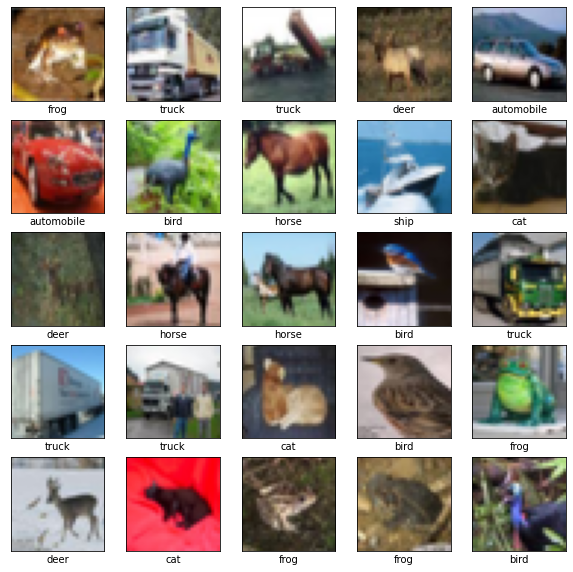

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Convolutional Neural Network

In [20]:
convolution_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10),
])

convolution_model.summary()

convolution_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)              

In [22]:
conv_history = convolution_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
196/196 [==============================] - 4s 16ms/step - loss: 1.6479 - accuracy: 0.4012 - val_loss: 1.4070 - val_accuracy: 0.4989
Epoch 2/10
196/196 [==============================] - 3s 15ms/step - loss: 1.2513 - accuracy: 0.5548 - val_loss: 1.1686 - val_accuracy: 0.5911
Epoch 3/10
196/196 [==============================] - 3s 15ms/step - loss: 1.0879 - accuracy: 0.6175 - val_loss: 1.0399 - val_accuracy: 0.6388
Epoch 4/10
196/196 [==============================] - 3s 15ms/step - loss: 0.9856 - accuracy: 0.6563 - val_loss: 1.0403 - val_accuracy: 0.6378
Epoch 5/10
196/196 [==============================] - 3s 15ms/step - loss: 0.9054 - accuracy: 0.6850 - val_loss: 0.9583 - val_accuracy: 0.6662
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.8490 - accuracy: 0.7042 - val_loss: 0.9042 - val_accuracy: 0.6817
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.7965 - accuracy: 0.7217 - val_loss: 0.9041 - val_accuracy: 0.6903

### Loss plot

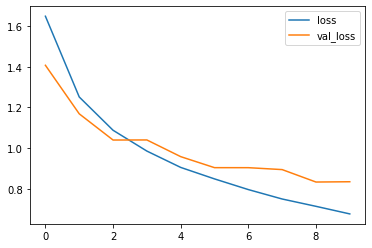

In [23]:
plt.plot(conv_history.history["loss"], label="loss")
plt.plot(conv_history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### Accuracy plot

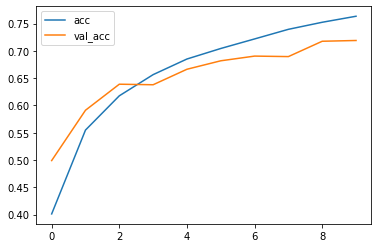

In [24]:
plt.plot(conv_history.history["accuracy"], label="acc")
plt.plot(conv_history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

# Involutional Neural Network

In [56]:
involution_model = tf.keras.models.Sequential([
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu1"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu2"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu3"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10),
])

involution_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [57]:
inv_history = involution_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
196/196 [==============================] - 5s 18ms/step - loss: 2.2165 - accuracy: 0.1908 - val_loss: 2.1230 - val_accuracy: 0.2472
Epoch 2/10
196/196 [==============================] - 3s 17ms/step - loss: 2.0188 - accuracy: 0.2893 - val_loss: 1.8933 - val_accuracy: 0.3332
Epoch 3/10
196/196 [==============================] - 3s 17ms/step - loss: 1.8428 - accuracy: 0.3497 - val_loss: 1.8160 - val_accuracy: 0.3609
Epoch 4/10
196/196 [==============================] - 3s 17ms/step - loss: 1.7716 - accuracy: 0.3760 - val_loss: 1.7572 - val_accuracy: 0.3831
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 1.7287 - accuracy: 0.3916 - val_loss: 1.7329 - val_accuracy: 0.3960
Epoch 6/10
196/196 [==============================] - 3s 16ms/step - loss: 1.6979 - accuracy: 0.4035 - val_loss: 1.6968 - val_accuracy: 0.4066
Epoch 7/10
196/196 [==============================] - 3s 16ms/step - loss: 1.6698 - accuracy: 0.4130 - val_loss: 1.6769 - val_accuracy: 0.4121

In [58]:
involution_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
involution_25 (Involution)   (None, 32, 32, 3)         26        
_________________________________________________________________
relu1 (ReLU)                 (None, 32, 32, 3)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 3)         0         
_________________________________________________________________
involution_26 (Involution)   (None, 16, 16, 3)         26        
_________________________________________________________________
relu2 (ReLU)                 (None, 16, 16, 3)         0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 3)           0         
_________________________________________________________________
involution_27 (Involution)   (None, 8, 8, 3)         

### Loss Plot

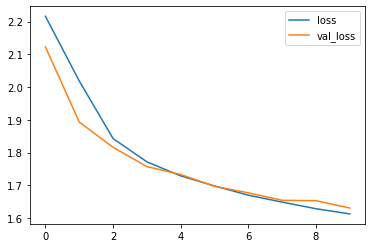

In [59]:
plt.plot(inv_history.history["loss"], label="loss")
plt.plot(inv_history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### Accuracy Plot

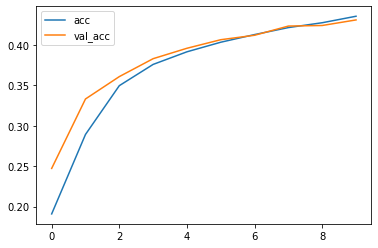

In [60]:
plt.plot(inv_history.history["accuracy"], label="acc")
plt.plot(inv_history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

### Observation

A fun little experiment is to see the activation maps of the involution kernel.

In [61]:
layer_names = ["relu1","relu2","relu3"]
outputs = [involution_model.get_layer(name).output for name in layer_names]

vis_model = tf.keras.Model(involution_model.input, outputs)

In [63]:
for im,_ in test_ds.take(1):
    images = vis_model(im)
    for index, name in layer_names:
        print(len(images))
        print(images[0].shape)
        for i in range(10):
            

3
(256, 32, 32, 3)


In [67]:
test_images[0].shape

(32, 32, 3)

In [71]:
len(vis_model.predict(tf.expand_dims(test_images[0],0)))

3

In [73]:
import numpy as np

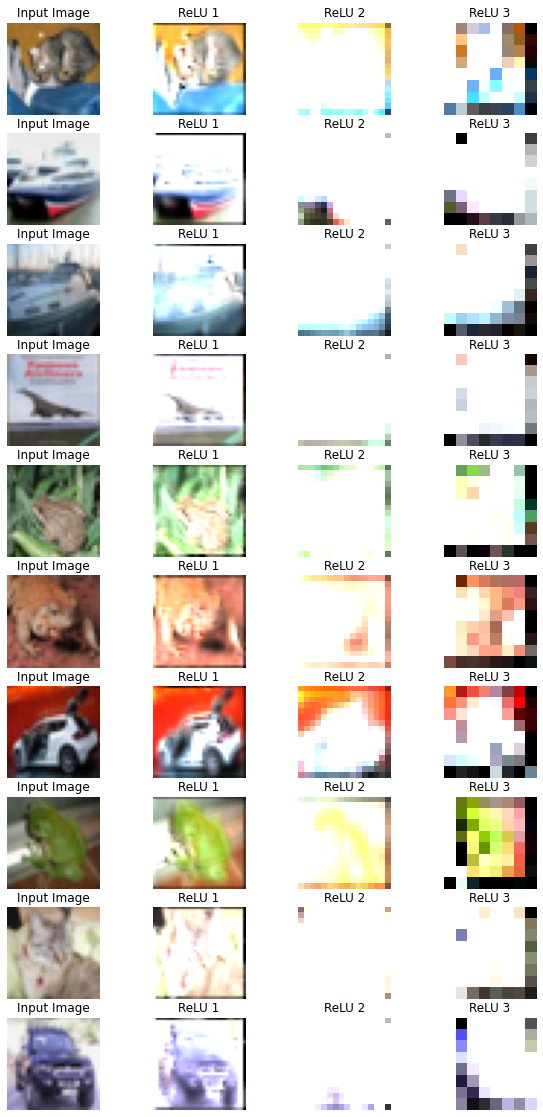

In [81]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))
[ax.axis("off") for ax in np.ravel(axes)]

for (ax_orig, ax_relu1, ax_relu2, ax_relu3), test_image in zip(axes, test_images[:10]):
    
    relu_images_list = vis_model.predict(tf.expand_dims(test_image,0))
    
    ax_orig.imshow(tf.clip_by_value(test_image, 0, 1))
    ax_orig.set_title("Input Image")

    ax_relu1.imshow(tf.clip_by_value(relu_images_list[0].squeeze(), 0, 1))
    ax_relu1.set_title("ReLU 1")

    ax_relu2.imshow(tf.clip_by_value(relu_images_list[1].squeeze(), 0, 1))
    ax_relu2.set_title("ReLU 2")

    ax_relu3.imshow(tf.clip_by_value(relu_images_list[2].squeeze(), 0, 1))
    ax_relu3.set_title("ReLU 3")